In [1]:
!export CUDA_VISIBLE_DEVICES=0

import os, torch, pdb

import numpy as np 
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from rdkit.Chem import AllChem

from escnn import gspaces, nn, group
from plotly.offline import init_notebook_mode

from vae_dist.dataset.fields import mat_pull, split_and_filter
from vae_dist.dataset.dataset import FieldDataset, dataset_split_loader
from vae_dist.core.O3VAE import R3VAE
from vae_dist.core.R3CNN import R3CNN
from vae_dist.core.VAE import baselineVAEAutoencoder
from vae_dist.core.CNN import CNNAutoencoderLightning
from vae_dist.data.visualize import get_latent_space, plot_vfield

init_notebook_mode(connected=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
from vae_dist.core.training import construct_model 
import json 


#options = json.load(open('./options/options_escnn_default.json'))
#log_save_dir = "./log_version_escnn_1/"
#model_escnn = construct_model("escnn", options)

#options = json.load(open('./options/options_esvae_default.json'))
#log_save_dir = "./log_version_esvae_1/"
#model_esvae = construct_model("esvae", options)

#options = json.load(open('./options/options_cnn_default.json'))
#log_save_dir = "./log_version_auto_1/"
#model_cnn = construct_model("auto", options)

options = json.load(open('./options/options_vae_default.json'))
log_save_dir = "./log_version_vae_1/"
model_vae = construct_model("vae", options)


#model.load_model("./log_version_auto_1/autoenc_1.ckpt")

inner_dim:  4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 17, 17, 17]          12,032
       BatchNorm3d-2       [-1, 32, 17, 17, 17]              64
              ReLU-3       [-1, 32, 17, 17, 17]               0
         ConvBatch-4       [-1, 32, 17, 17, 17]               0
           Dropout-5       [-1, 32, 17, 17, 17]               0
            Conv3d-6       [-1, 64, 14, 14, 14]         131,136
       BatchNorm3d-7       [-1, 64, 14, 14, 14]             128
              ReLU-8       [-1, 64, 14, 14, 14]               0
         ConvBatch-9       [-1, 64, 14, 14, 14]               0
          Dropout-10       [-1, 64, 14, 14, 14]               0
           Conv3d-11      [-1, 128, 12, 12, 12]         221,312
      BatchNorm3d-12      [-1, 128, 12, 12, 12]             256
             ReLU-13      [-1, 128, 12, 12, 12]               0
        ConvBatch-14     

In [3]:
#model_esvae.load_model("./log_version_esvae_1/model_1.ckpt")
model_vae.load_model("./log_version_vae_1/model_1.ckpt")
# move model to gpu 
#model_esvae.to(device)
model_vae.to(device)

Model Created!


baselineVAEAutoencoder(
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
  (encoder_conv): Sequential(
    (0): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(3, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Dropout(p=0.1, inplace=False)
    (2): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): Dropout(p=0.1, inplace=False)
    (4): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=Tr

In [19]:
model_esvae.load_model("./log_version_esvae_1/model_1.ckpt")
#model_cnn.to(device)
model_esvae.to(device)

Model Created!


R3VAE(
  (fc_mu): Linear(in_features=10, out_features=10, bias=True)
  (fc_var): Linear(in_features=10, out_features=10, bias=True)
  (encoder_fully_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=48, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=10, bias=True)
    (6): ReLU()
  )
  (decoder_fully_net): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=48, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(48, 1, 1, 1))
  )
  (decoder): SequentialModule(
    (0): R3ConvTransposed([O(3)_on_R3[o3]: {irrep_0,0 (x48)}(48)], [O(3)_on_R3[o3]: {irrep_0,0 (x240)}(240)], kernel_size=5, stride=1, padding=2, bias=False)
    (1): ReLU(inplace=True, type

In [4]:
root = "../../data/augment_test/"
dataset_test = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    log_scale=True, 
    device=device
    )

dataset_loader_full = torch.utils.data.DataLoader(
        dataset_test, 
        batch_size=10,
        shuffle=True,
        num_workers=0
    )

Largest value in dataset:  1.1280309724831943
Smallest value in dataset:  -1.5775816863113294


In [5]:
root = "../../data/cpet/"

dataset = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    log_scale=True, 
    device=device
    )

Largest value in dataset:  1.0304299865539772
Smallest value in dataset:  -1.2890294168026475


# Latent Space Plotting

Total number of fields:  187


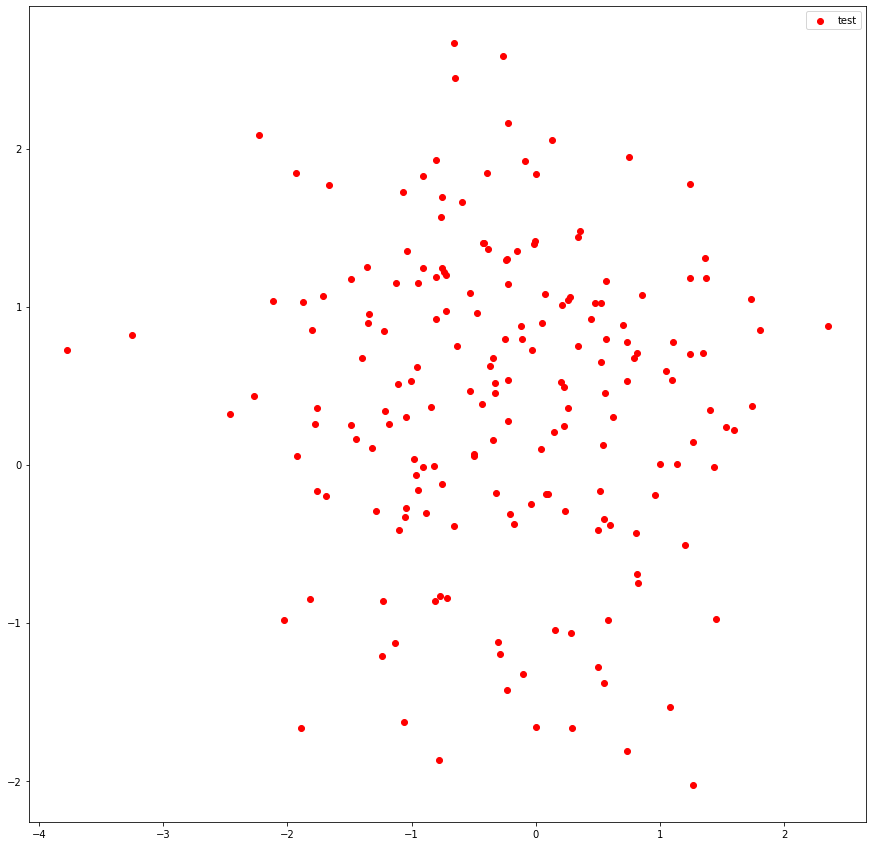

1.7622709780086254


In [11]:
plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model_vae, dataset, comp=[0, 1], latent_dim=2)
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
plt.legend()
plt.show()


mean_dist = 0
for i in range(latent_space.shape[0]):
    for j in range(latent_space.shape[0]):
        mean_dist += np.linalg.norm(latent_space[i] - latent_space[j])
mean_dist /= latent_space.shape[0]**2
print(mean_dist)

Total number of fields:  9


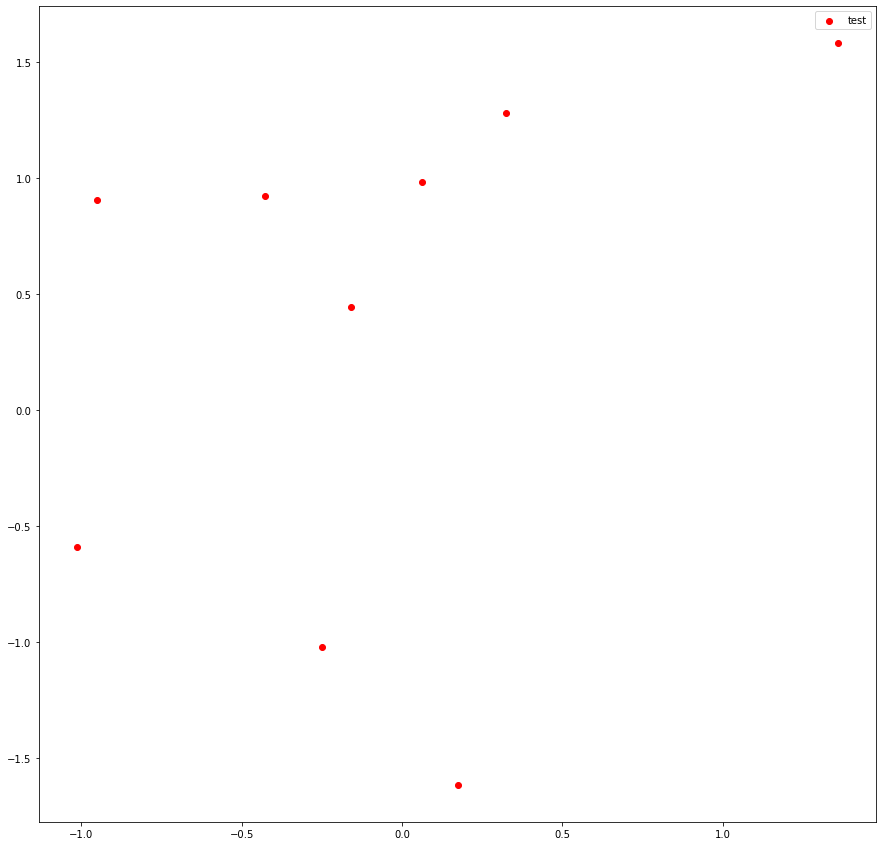

1.4971719200228468


In [10]:
plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model_vae, dataset_test, comp=[0, 1], latent_dim=2)
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
plt.legend()
plt.show()
# compute average distance between points in latent space
mean_dist = 0
for i in range(latent_space.shape[0]):
    for j in range(latent_space.shape[0]):
        mean_dist += np.linalg.norm(latent_space[i] - latent_space[j])
mean_dist /= latent_space.shape[0]**2
print(mean_dist)

In [29]:
# Rotations on latent space

root = "../../data/augment_test/"
dataset_aug = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )


plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model, dataset, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
latent_space = get_latent_space(model, dataset_aug, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="green", label="augment")

plt.legend()
plt.show()



Largest value in dataset:  0.9999994960772131
Smallest value in dataset:  -0.3471241882433806
Total number of fields:  187


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_bmm)

<Figure size 1080x1080 with 0 Axes>

# run the equivariance test


In [11]:


def equiv_test(model, dataset_test, device):
    print('##########################################################################################')
    with torch.no_grad():
        #x = next(iter(dataset_test)).reshape(1, 3, 21, 21, 21).to(device)
        x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
        y = model(x).to('cpu')
        print("Outputs' magnitudes")
        print(torch.linalg.norm(y, dim=1).numpy().reshape(-1))
        # print largest value 
        print("Largest value")
        print(torch.max(torch.linalg.norm(y, dim=1)).numpy())
        print('##########################################################################################')
        print("Errors' magnitudes")
        for r in range(8):
            # sample a random rotation
            g = groupie.sample()
            x_equi = feat_type_in(dataset_test[r].reshape(1, 3, 21, 21, 21).to(device))
            x_transformed = g @ x_equi
            x_transformed = x_transformed.to(device)
            y_transformed = model(x).to('cpu')
            
            y_group_rep = feat_type_in(y)
            # verify that f(g@x) = g@f(x)=g@y
            # print maximum error
            #print(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1).numpy().reshape(-1))        
            print("Largest error")
            print(torch.max(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1)).numpy())
    print('##########################################################################################')
    print()
equiv_test(model, dataset_test, device)

##########################################################################################
Outputs' magnitudes
[3.063006e-05 3.063006e-05 3.063006e-05 ... 3.063006e-05 3.063006e-05
 3.063006e-05]
Largest value
0.75596917
##########################################################################################
Errors' magnitudes
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
##########################################################################################



In [109]:
model_fresh = R3Net(
        0.0005,
        group_space,
        feat_type_in = feat_type_in, 
        feat_type_out = feat_type_out, 
        kernel_size=kernel_size,
        latent_dim=10, 
        fully_connected_dims=[100, 100, 100]
    )
model_fresh = model_fresh.cuda()
equiv_test(model_fresh, dataset_test, device)

48 100
100 100
100 10
##########################################################################################
Outputs' magnitudes
[2.8252327e-05 2.8252327e-05 2.8252327e-05 ... 2.8252327e-05 2.8252327e-05
 2.8252327e-05]
Largest value
0.26404372
##########################################################################################
Errors' magnitudes
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
##########################################################################################



# Visualize in/out field from model


In [7]:




plot_vfield(
        dataset.data[0], 
        cutoff_low = 70, 
        cutoff_high=100, 
        min_max = False,
        scale = 2)
#fig.show()
#fig.write_html("cones_.html")

0.27 0.3 0.52


In [8]:
# model reconstruction

x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
x_out = model_vae.forward(x)
x_out = x_out.to('cpu').detach().numpy().reshape(3, 21, 21, 21)

plot_vfield(
        x_out, 
        cutoff_low = 0, 
        cutoff_high=100, 
        min_max = False,
        scale = 2)


11.44 9.56 8.39


# Q-Q Plot

In [15]:
# q-q plot of the latent space

latent_space = get_latent_space(model, dataset, comp=[0, 1], latent_dim=2)

import scipy.stats as stats
import pylab 
import statsmodels.api as sm
sm.qqplot(latent_space[:,1], line='45')
pylab.show()



NameError: name 'get_latent_space' is not defined

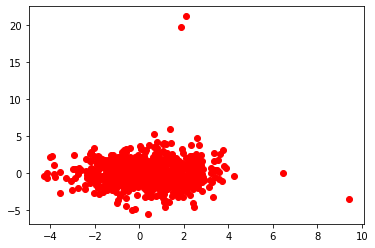

In [29]:
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
